In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-0.5B-Chat")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B-Chat")
%load_ext autoreload
%autoreload 2

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
import os
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {} '.format(device))


Device: cuda 


In [8]:
model.to(device)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (down_proj): Linear(in_features=2816, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (lm_head): Line

- dimension 0 : taille du batch
- dimension 1 : taille de la séquence
- dimension 2 : taille de la représentation

On aura donc des tailles variables de sortie en fonction de la taille de la séquence d'entrée. 

Comment faire pour l'utiliser pour la classification ?

- utiliser le token `[CLS]` (modéle basé sur bert) qui est le premier token de la séquence (espece de représentation de la séquence entière) nous on est sur sententpiece `<s>` pas le meme role mais peut etre qu'on peut l'utiliser de la meme facon
- average pooling : moyenne des représentations des tokens de la séquence
- max pooling : max des représentations des tokens de la séquence
- system d'attention : on va donner un poids à chaque token de la séquence et on va faire une somme pondérée des représentations des tokens

## Creating the dataset of weights

In [10]:
import pandas as pd
#list of datasets to create activations
#datasets_list = ["curated/cities_cities_conj","curated/cities_cities_disj","curated/larger_than","curated/neg_cities",
                 #"curated/neg_sp_en_trans","curated/smaller_than","curated/sp_en_trans","likely/likely",
                 #"uncurated/companies_true_false","uncurated/counterfact_true_false"]
datasets_list = ["curated/cities_new"]
for dataset_name in datasets_list:
    
    raw_data = pd.read_csv(f"../data/true-false-datasets/{dataset_name}.csv")

    #check if the name exist in activation folder
    if not os.path.exists(f"../activations/{dataset_name}_chat"):
        os.makedirs(f"../activations/{dataset_name}_chat")

    print("Nombre de lignes: ", raw_data.shape[0])
    raw_data.head() 

Nombre de lignes:  1496


We keep only the statement and its label. We will use the statement to create the weights.

In [6]:
from transformers import set_seed
#set seed for reproducibility
set_seed(42)

In [11]:
from tqdm import tqdm

nb_neurons_per_layer = model.model.layers[5].self_attn.k_proj.in_features
nb_layer = model.model.layers.__len__()

activations = {}
#defining the layers to extract activations
#layers_num = [i for i in range(0,nb_layer)]
layers_num = [0 ,7, 10, 12, 15, 22]
hooks = []
model_name = "Qwen1.5-0.5B_chat"

class StopForwarding(Exception):
    pass

#function to capture the output of the layer    
def capture_output(module, input, output, layer_num):
    output = output[0].detach()
    activations[f'layer_{layer_num}_output'] = output[:,-1,:]
    if layer_num == layers_num[-1]:
        raise StopForwarding

#registering the hooks
for layer_num in layers_num:
    hooks.append(model.model.layers[layer_num].register_forward_hook(lambda module, input, output, layer_num=layer_num: capture_output(module, input, output, layer_num)))

#loop over the datasets
for dataset_name in datasets_list:
    raw_data = pd.read_csv(f"../data/true-false-datasets/{dataset_name}.csv")
    
    pbar = tqdm(total=raw_data.shape[0], desc=f"Processing lines of {dataset_name}", unit="line")
    pbar.update(0)
    #loop over the lines of the dataset
    for i in range(0,raw_data.shape[0]) :
        try :
            """
            in this part we tokenize the statement and pass it to the model to get the activations of the layers
            the raise StopForwarding is used to stop the forward pass of the model when we get the activations of the layers
            to reduce the computation time
            """ 
            statement = raw_data.iloc[i,0]
            #message = [
            #    {"role": "system", "content": "You are a helpful assistant and will only answer with False or True."},
            #    {"role": "user", "content": statement}
            #]
            label = raw_data.iloc[i,1]
            #text = tokenizer.apply_chat_template(
            #    message,
            #    tokenize=False,
            #    add_generation_prompt=True
            #)
            input_token = tokenizer([statement], return_tensors="pt")
            #input_token = tokenizer.encode_plus(text, return_tensors="pt")
            input_ids = input_token["input_ids"].to(device)
            mask = input_token["attention_mask"].to(device)
            
            with torch.no_grad():
                output = model(input_ids=input_ids, attention_mask=mask)
                
        except StopForwarding:
            """
            we just save the activations of the layers in a csv file
            """
            for layer_num in layers_num:
                layer_output = activations[f'layer_{layer_num}_output']
                layer_output = layer_output.cpu().numpy()
                start_neuron = nb_neurons_per_layer * layer_num +1
                end_neuron = start_neuron + nb_neurons_per_layer
                layer_output = pd.DataFrame(layer_output, columns=[f'neuron_{i}' for i in range(start_neuron, end_neuron)])
                layer_output["label"] = label
                header = i == 0
                layer_output.to_csv(f"../activations/{dataset_name}_chat/{model_name}_layer_{layer_num}_output.csv", mode='a', index=False, header=header)
        
        pbar.update(1)
    pbar.close()
    
for hook in hooks:
    hook.remove()

Processing lines of curated/cities_new: 100%|██████████| 1496/1496 [01:17<00:00, 19.33line/s]


## Load the csv of the weights

In [ ]:
layer_num = 12
df = pd.read_csv(f"../activations/{dataset_name}/{model_name}_layer_{layer_num}_output.csv")
df.shape

In [22]:
features = df.drop(["label"], axis=1)
labels = df["label"]
features.shape, labels.shape

((4450, 2048), (4450,))

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)

In [26]:
#concatenate df[df.columns[-1]] and pca_result
pca_result = pd.DataFrame(pca_result, columns=["pca1", "pca2", "pca3"])
pca_result["label"] = labels
pca_result.head(), pca_result.shape

(       pca1      pca2      pca3  label
 0  4.958761  1.039797 -4.760369      1
 1  1.725020 -6.407079  5.457721      1
 2 -3.421555 -0.667109  4.962538      1
 3  0.850217 -6.919902 -5.997299      1
 4  7.056195 -3.071302  1.458882      1,
 (4450, 4))

<Axes: xlabel='pca1', ylabel='pca2'>

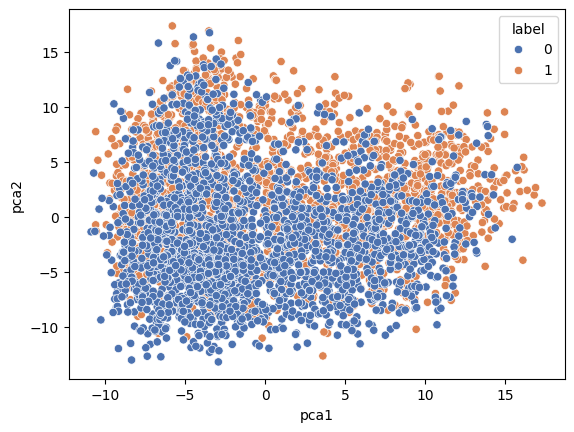

In [27]:
#plot the pca_result with the label as color
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.scatterplot(
    x="pca1", y="pca2",
    hue="label",
    palette=sns.color_palette("deep", 2),
    data=pca_result,
    legend="full",
)

In [28]:
import plotly.express as px

fig = px.scatter_3d(pca_result, x='pca1', y='pca2', z='pca3', color='label')

fig.update_layout(
    title='3D Interactive Plot',
    scene=dict(
        xaxis_title='PCA 1',
        yaxis_title='PCA 2',
        zaxis_title='PCA 3'
    )
)